In [1]:
using Revise
using LoopVectorization
using Distributions
using BeamPropagation, StaticArrays, DelimitedFiles, BenchmarkTools
using Plots, StructArrays, StatsBase, StatsPlots
using PhysicalConstants.CODATA2018
using LinearAlgebra

# Define Constants

In [2]:
# Define constants
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Γ = @with_unit 2π * 6.4 "MHz"
const Iₛ = @with_unit 3.4 "mW/cm^2"
;

In [3]:
const Ng = 12
const Ne = 4
const Γeff = 2*Ne/(Ng+Ne)*Γ
const ζ = 0.21
const μ_B = BohrMagneton.val
;

# Functions to pass to propagation code

In [532]:
@inline function rotpol(kvec_in, bvec_in, pol_in) #rotate polarization onto local quantization axis defined by bvec
    # kvec and bvec are in cartesian (x,y,z) coordinates, and pol_in and pol_out are in spherical (+,-,z) coordinates
    
    kvec = kvec_in/norm(kvec_in)
    zvec = SVector(0.,0.,1.) #z axis, which will also be involved in the necessary rotations
    
    if norm(bvec_in) == 0
        bvec = kvec
    else
        bvec = bvec_in/norm(bvec_in)
    end
        
    Usc = @SMatrix [-1/sqrt(2) 1/sqrt(2) 0.;
                            -1im/sqrt(2) -1im/sqrt(2) 0.;
                            0. 0. 1.] #converts from spherical (+,-,z) to cartesian (x,y,z)
    Uscdag = conj(transpose(Usc)) #converts from cartesian to spherical

    pol_in_cart = Usc*pol_in
#     pol_in_cart = pol_in

    #the approach is to first find the rotation matrix that rotates the z axis onto the k vector (alternatively, a passive rotation of k into z)
        #then apply to the polarization; this will express the polarization (initially in the "k frame") in the "lab frame"
        #we next rotate this into the frame where the B/quantization axis is the z axis, projecting into the "atom frame"
    
    #perhaps a better way to think of this (?):
    #with the polarization vector fixed in space, apply several passive coordinate rotations
    #first, rotate the coordinates from the k-vector frame (in which the polarization is initially defined) to the lab frame
    #then, rotate the coordinates into the B vector/quantization axis frame, which gives the polarization in terms of the "atom frame" coordinates
    #Question: why is the intermediate step necessary, i.e. why can't we just directly rotate coordinates from the k frame to the B frame?
    #Answer: the rotation matrices we're using are expressed in the lab frame basis, so all rotations need to be referenced to that basis

    #find rotation matrix that rotates zvec into kvec using Rodrigues' formula

    if zvec == kvec
        rrot1 = SMatrix{3,3, Float64}(1I)
        
    elseif zvec == -kvec
        #in this case, choose the rotation to (arbitrarily) be about the y axis
        rrot1 = @SMatrix [-1. 0. 0.;
                            0. 1. 0.;
                            0. 0. -1.]
        
    else
        vvec = cross(zvec,kvec)
        vvecn = vvec/norm(vvec) #unit vector specifying rotation axis
        ccos = dot(zvec,kvec)/norm(zvec)/norm(kvec) #cosine of angle between zvec and kvec
        ssin = sqrt(1-ccos^2) #sine of angle between zvec and kvec


        vxmat = @SMatrix [0. -vvecn[3] vvecn[2];
                            vvecn[3] 0. -vvecn[1];
                            -vvecn[2] vvecn[1] 0.] # "cross-product matrix"

        rrot1 = SMatrix{3,3}(1I) + ssin*vxmat + (1-ccos)*vxmat*vxmat
    end

    #now find rotation matrix that rotates zvec into bvec using Rodrigues' formula

    if zvec == bvec
        rrot2 = SMatrix{3,3, Float64}(1I)
        
    elseif zvec == -bvec
        #in this case, choose the rotation to (arbitrarily) be about the y axis
        rrot2 = @SMatrix [-1. 0. 0.;
                            0. 1. 0.;
                            0. 0. -1.]
        
    else
        vvec = cross(zvec,bvec)
        vvecn = vvec/norm(vvec) #unit vector specifying rotation axis
        ccos = dot(zvec,bvec)/norm(zvec)/norm(bvec) #cosine of angle between zvec and bvec
        ssin = sqrt(1-ccos^2) #sine of angle between zvec and bvec


        vxmat = @SMatrix [0. -vvecn[3] vvecn[2];
                            vvecn[3] 0. -vvecn[1];
                            -vvecn[2] vvecn[1] 0.] # "cross-product matrix"

        rrot2 = SMatrix{3,3}(1I) + ssin*vxmat + (1-ccos)*vxmat*vxmat
    end

    #now rotate polarization onto the new quantization axis
    pol_out_cart = transpose(rrot2)*rrot1*pol_in_cart
    pol_out_raw = Uscdag*pol_out_cart
#     pol_out_raw = pol_out_cart
    pol_out = pol_out_raw/norm(pol_out_raw)
            
    return pol_out
    
end

rotpol (generic function with 1 method)

Some testing for this function

In [539]:
kvec = @SVector [1.,1.,0.]
bvec = @SVector [-1.,-1.,0.]
polin = @SVector [1.,0.,0.]

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 1.0
 0.0
 0.0

In [535]:
@btime rotpol($kvec, $bvec, $polin)

  69.017 ns (0 allocations: 0 bytes)


3-element SArray{Tuple{3},Complex{Float64},1,3} with indices SOneTo(3):
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [540]:
out = rotpol(kvec, bvec, polin)

3-element SArray{Tuple{3},Complex{Float64},1,3} with indices SOneTo(3):
 -6.835808657661923e-17 + 0.0im
                    0.0 + 1.0im
 -2.057857651608679e-16 - 2.057857651608679e-16im

In [278]:
function polproject_angle(theta,pol_coord)
    kvec = @SVector [1.,0.,0.]
    polin = @SVector [1.,0.,0.]
    bmag = 1.
    bangle = theta*pi/180
    bvec = @SVector[bmag*cos(bangle), bmag*sin(bangle), 0]
    polout = rotpol(kvec,bvec,polin)
    out = dot(polout,pol_coord)
    return abs2(out)
end

polproject_angle (generic function with 1 method)

In [279]:
polout = polproject_angle(0,[1., 0., 0.])

1.0

In [541]:
thetalist = 0:180 #degrees
polsoutp = zeros(length(thetalist))
polsoutm = zeros(length(thetalist))
polsoutz = zeros(length(thetalist))
for i in 1:length(thetalist)
    polsoutp[i] = polproject_angle(thetalist[i],[1., 0., 0.])
    polsoutm[i] = polproject_angle(thetalist[i],[0., 1., 0.])
    polsoutz[i] = polproject_angle(thetalist[i],[0., 0., 1.])
end

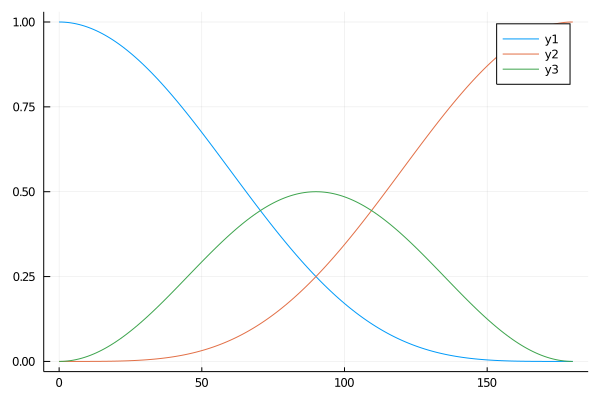

In [542]:
plot(thetalist,polsoutp)
plot!(thetalist,polsoutm)
plot!(thetalist,polsoutz)

In [12]:
@inline function Bfield(r,grad) #returns B field, in Gauss, given input position (m) and gradient (G/cm)
    x, y, z = r
    Bout = @SVector [1e2*grad*x, 1e2*grad*y, -2*grad*z*1e2]
    return Bout
end

@inline function ΔZeeman(r, ig, ie, grad) #calculate detuning due to Zeeman shifts for transition from ground state ig to excited state ie
    gg = @SVector [0.]
    ge = @SVector [-1., 0., 1.]
    
    Bmag = norm(Bfield(r,grad))
    Eg = 1e-4 * μ_B*gg[ig]*Bmag/ħ
    Ee = 1e-4 * μ_B*ge[ie]*Bmag/ħ
    
    return Eg-Ee
end

ΔZeeman (generic function with 1 method)

In [381]:
@btime Bfield($rtest,$grad)

  0.001 ns (0 allocations: 0 bytes)


3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
   0.0
   0.0
 -20.0

In [382]:
rtest = @SVector [1e-2, 0., 1e-2]
Bfield(rtest,1.)
norm(Bfield(rtest,1.))

2.23606797749979

In [385]:
@btime ΔZeeman($rtest,1,3,1.)

  2.499 ns (0 allocations: 0 bytes)


-1.966420552123554e7

In [103]:
ΔZeeman(rtest,1,3,1.)/(2*pi*1e6)

-3.129655510679577

In [14]:
@inline function sat(r,i)
    return 1
end

@inline function satp(r)
   return 1 
end

satp (generic function with 1 method)

In [392]:
# @inline function f(idx, r, v, p)
#     x, y, z = r
#     vx, vy, vz = v
    
#     Bvec = Bfield(r,p.grad)
    
#     forces = @MMatrix zeros(size(laserks,1),3)
# #     forces = zeros(size(laserks,1),3)
#     for i in 1:size(laserks,1)
#         pol = rotpol(laserks[i,:],Bvec,laserpols[i,:]) 
#         for ig in 1:ng_eff
#             for ie in 1:ne_eff
#                 Δi =  p.δ - dot(laserks[i,:],v) + ΔZeeman(r,ig,ie,p.grad)
#                 Ri = Γeff/2*sat(r,i)/(1+satp(r)+4*Δi^2/Γ^2)*(dot(pol,fmat[ig,ie,:]))^2
#                 #the dot product in the last term accounts for overlap of the local polarization with that needed to drive transition between ig and ie
#                 forces[i,:] = forces[i,:] +  ħ*laserks[i,:]*Ri
#             end
#         end
#     end
    
#     force_out = sum(forces,dims=1)
#     force_out = force_out/m
    
# #     for i in 1:size(laserks,2)
# #        pol[i] = rotpol(laserks[i,:],Bvec,laserpols[i,:]) #need to preallocate 
# #     end
    
# #     Δs = p.δ + laserks*v + μ_B*Bfield(r,p.grad)/ħ
    
#     return force_out
# end

f (generic function with 1 method)

In [200]:
@inline function f(idx, r, v, p)
    x, y, z = r
    vx, vy, vz = v
    
    Bvec = Bfield(r,p.grad)
    
#     forces = @MMatrix zeros(size(laserks,1),3)
#     forces = zeros(size(laserks,1),3)
    fx = 0
    fy = 0
    fz = 0
    for i in 1:size(p.laserks,1)
        pol = rotpol(p.laserks[i],Bvec,p.laserpols[i]) 
        for ig in 1:p.ng_eff
            for ie in 1:p.ne_eff
                Δi = p.δ + ΔZeeman(r,ig,ie,p.grad)
                pol_fmat_dot = 0
                for j in 1:3
                    Δi += -p.laserks[i][j]*v[j]
                    pol_fmat_dot += pol[j]*p.fmat[ig,ie,j]
                end
                Ri = Γeff/2*sat(r,i)/(1+satp(r)+4*Δi^2/Γ^2)*abs2(pol_fmat_dot)
                #the dot product in the last term accounts for overlap of the local polarization with that needed to drive transition between ig and ie
                fx += ħ*p.laserks[i][1]*Ri
                fy += ħ*p.laserks[i][2]*Ri
                fz += ħ*p.laserks[i][3]*Ri
            end
        end
    end
    
#     for i in 1:size(laserks,2)
#        pol[i] = rotpol(laserks[i,:],Bvec,laserpols[i,:]) #need to preallocate 
#     end
    
#     Δs = p.δ + laserks*v + μ_B*Bfield(r,p.grad)/ħ
    
    return SVector(fx/m,fy/m,fz/m)
end

f (generic function with 1 method)

In [493]:
laserks = [SVector(1., 0., 0.),
            SVector(-1., 0., 0.),
            SVector(0., 1., 0.),
            SVector(0., -1., 0.),
            SVector(0., 0., 1.),
            SVector(0., 0., -1.)]
laserks = k*laserks

laserpols = [SVector(1., 0., 0.),
                        SVector(1., 0., 0.),
                        SVector(1., 0., 0.),
                        SVector(1., 0., 0.),
                        SVector(0., 1., 0.),
                        SVector(0., 1., 0.)]

6-element Array{SArray{Tuple{3},Float64,1,3},1}:
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 1.0, 0.0]

In [113]:
ng_eff = 1
ne_eff = 3
fmat = zeros(Complex{Float64}, ng_eff,ne_eff,3) #matrix of transition strengths
#this is complex since it will be dotted with a complex polarization unit vector
fmat[:, :, 1] = [0., 0., 1.] # σ+ polarized
fmat[:, :, 2] = [1., 0., 0.] # σ- polarized
fmat[:, :, 3] = [0., 1., 0.] # π polarized

3-element Array{Float64,1}:
 0.0
 1.0
 0.0

In [494]:
δ = @with_unit 2π * (-7) "MHz"
grad = 10 #G/cm
p = @params (δ, grad, laserks, laserpols, ng_eff, ne_eff, fmat)

(δ = -4.39822971502571e7, grad = 10, laserks = SArray{Tuple{3},Float64,1,3}[[1.0037037231916271e7, 0.0, 0.0], [-1.0037037231916271e7, 0.0, 0.0], [0.0, 1.0037037231916271e7, 0.0], [0.0, -1.0037037231916271e7, 0.0], [0.0, 0.0, 1.0037037231916271e7], [0.0, 0.0, -1.0037037231916271e7]], laserpols = SArray{Tuple{3},Float64,1,3}[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0]], ng_eff = 1, ne_eff = 3, fmat = Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im]

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im])

In [543]:
rtest = [1e-2, 1e-2, 1e-2]
vtest = [1., -1., 0.5]

3-element Array{Float64,1}:
  1.0
 -1.0
  0.5

In [544]:
@btime out = f(1,$rtest,$vtest,$p)

  948.543 ns (0 allocations: 0 bytes)


3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 -4852.08586793344
  4158.605044345131
 -1531.5670733468355

## Plots

In [545]:
vlist = -15:0.5:15
aout = zeros(length(vlist))
for i in 1:length(vlist)
    out = f(1,SVector(0.,0.,0.),SVector(0.,0.,vlist[i]),p)
    aout[i] = out[3]
end

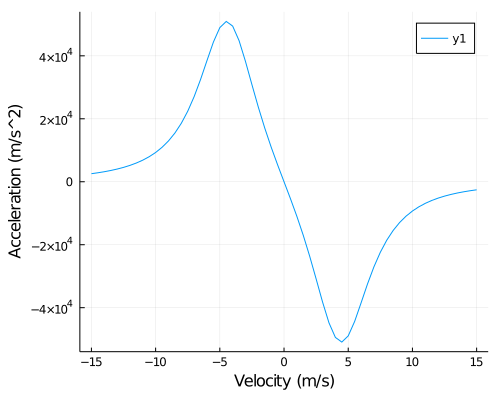

In [546]:
plot(vlist,aout)
xlabel!("Velocity (m/s)")
ylabel!("Acceleration (m/s^2)")
plot!(size=(500,400))

In [547]:
xlist = -10e-3:0.5e-3:10e-3
aout1 = zeros(length(xlist))
aout2 = zeros(length(xlist))
for i in 1:length(xlist)
    out1 = f(1,SVector(xlist[i],0.,0.),SVector(0.,0.,0.),p)
    aout1[i] = out1[1]
    out2 = f(1,SVector(0.,0.,xlist[i]),SVector(0.,0.,0.),p)
    aout2[i] = out2[3]
end

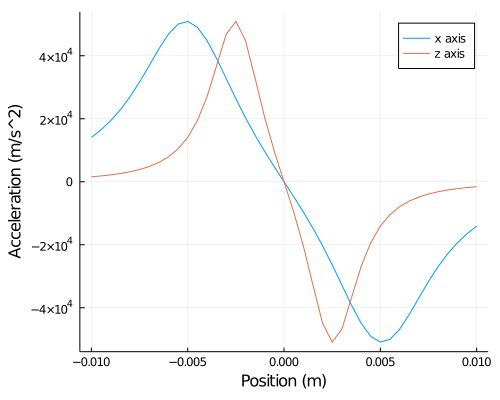

In [548]:
plot(xlist,aout1,label="x axis")
plot!(xlist,aout2, label = "z axis")
xlabel!("Position (m)")
ylabel!("Acceleration (m/s^2)")
plot!(size=(500,400))

Will this work at off-axis?

In [554]:
xlist = -10e-3:0.5e-3:10e-3
theta = 20*pi/180 #degrees
aout = zeros(length(xlist))
thetaout = zeros(length(xlist))
out = 0
for i in 1:length(xlist)
    out = f(1,SVector(xlist[i]*cos(theta),xlist[i]*sin(theta),0.),SVector(0.,0.,0.),p)
    aout[i] = out[1]*cos(theta)+out[2]*sin(theta)
    thetaout[i] = 180/pi*atan(out[2],out[1])
end

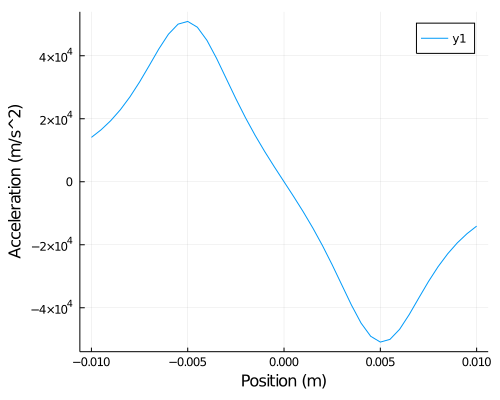

In [555]:
plot(xlist,aout)
xlabel!("Position (m)")
ylabel!("Acceleration (m/s^2)")
plot!(size=(500,400))

In [556]:
thetaout

41-element Array{Float64,1}:
   20.000000000000007
   20.000000000000004
   20.000000000000004
   20.000000000000004
   20.00000000000001
   20.0
   20.0
   20.00000000000001
   20.00000000000001
   20.0
   19.999999999999993
   20.0
   20.00000000000001
    ⋮
 -160.0
 -160.00000000000003
 -160.00000000000003
 -160.0
 -160.0
 -160.0
 -160.0
 -160.0
 -160.0
 -160.0
 -160.0
 -160.0

In [ ]:
@inline function discard(r,v) 
    return false
end

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        dt = particles.dt[i]
        r = particles.r[i]
        vz = particles.v[i][3]
        vx = particles.v[i][1]
        
        push!(s.rs[idx], r)
        push!(s.vzs[idx], vz)
        push!(s.vxs[idx], vx)
        push!(s.dts[idx], dt)
    end
    return nothing
end